### 0. Import libraries and load data

In [1]:
%reload_ext autoreload

import os
import sys
import json
from collections import Counter

# utils
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt 

# custom scripts
sys.path.append(os.path.realpath('../../src/'))
from utils import load_save_data

sns.set()
matplotlib.rcParams.update({'font.size': 32})

In [3]:
data_loader = load_save_data.DataLoader("../../data/")
raw_data = data_loader.load_data()
raw_data

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

### 1. Analyze context-question pairs

In [3]:
def analyze_contexts_questions(raw_data, data_set_type="train"):
    data_df = pd.DataFrame(raw_data[data_set_type])

    contexts = data_df["context"].to_list()
    questions = data_df["question"].to_list()

    contexts_questions = list(zip(contexts, questions))
    context_question_length = [len(question.strip().split(" ")) + len(context.strip().split(" ")) for question, context in contexts_questions]

    quantile_95 = np.quantile(context_question_length, .95)
    quantile_99 = np.quantile(context_question_length, .99)

    print(f"95 quantile: {int(quantile_95)} tokens\n99 quantile: {int(quantile_99)} tokens")

    plt.boxplot(context_question_length)
    plt.title(f"Context length in terms of tokens for {data_set_type} data")

    plt.show()

95 quantile: 223 words
99 quantile: 293 words


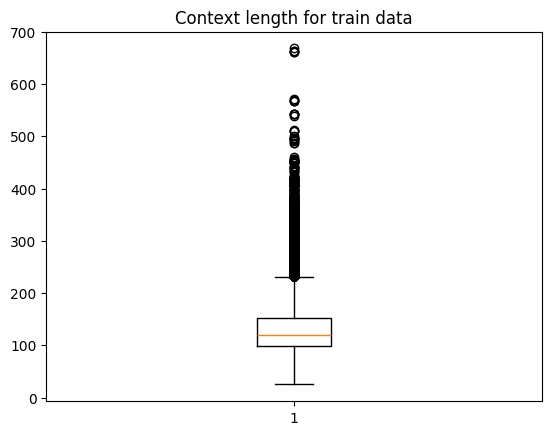

In [4]:
analyze_contexts_questions(raw_data, data_set_type="train")

95 quantile: 230 words
99 quantile: 347 words


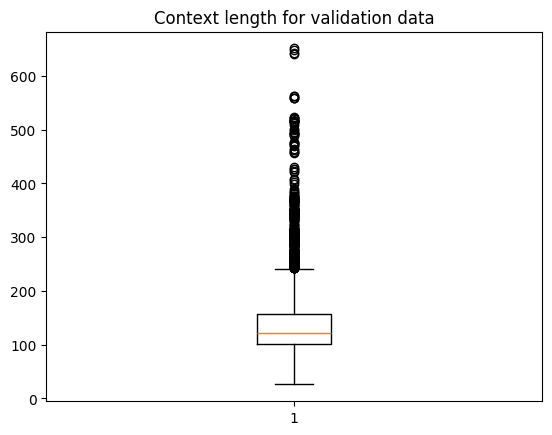

In [5]:
analyze_contexts_questions(raw_data, data_set_type="validation")

### 2. Analyze answers

In [34]:
def analyze_answers(raw_data, data_set_type="train"):
    answer_lengths = []

    for answers in raw_data[data_set_type]["answers"]:
        if data_set_type == "train":
            answer_lengths.append(len(answers["text"][0]))
        elif data_set_type == "validation":
            answer_lengths.append(max([len(answer) for answer in answers["text"]]))

    quantile_95 = np.quantile(answer_lengths, .95)
    quantile_99 = np.quantile(answer_lengths, .99)

    print(f"95 quantile: {int(quantile_95)} tokens\n99 quantile: {int(quantile_99)} tokens")

    plt.boxplot(answer_lengths)
    plt.title(f"Context length in terms of tokens for {data_set_type} data")

95 quantile: 63 tokens
99 quantile: 117 tokens


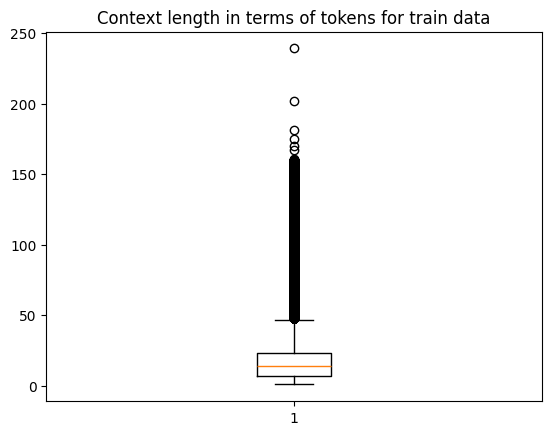

In [35]:
analyze_answers(raw_data, data_set_type="train")

95 quantile: 72 tokens
99 quantile: 121 tokens


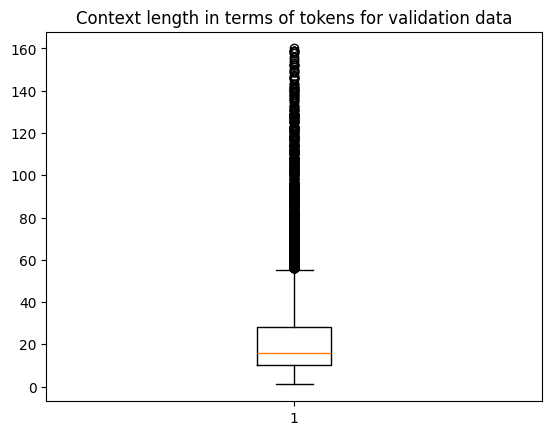

In [36]:
analyze_answers(raw_data, data_set_type="validation")

### 3. Check question types

In [2]:
input_file_path = "../../data/squad_data_train_pos_ner.json"
data = []

with open(input_file_path) as f:
    for line in f:
        data.append(json.loads(line))

In [3]:
input_file_path = "../../data/squad_data_validation_pos_ner.json"
data_val = []

with open(input_file_path) as f:
    for line in f:
        data_val.append(json.loads(line))

In [4]:
questions_no = len(data) + len(data_val)
question_words_freq = {'what':0, 'where':0, 'when':0, 'who':0, 'why':0, 'which':0, 'whom':0, 'how':0, 'whose':0}

for line in data:
    first_word = line["question"].split(" ")[0].lower()

    if first_word in list(question_words_freq.keys()):
        question_words_freq[first_word] += 1

for line in data_val:
    first_word = line["question"].split(" ")[0].lower()

    if first_word in list(question_words_freq.keys()):
        question_words_freq[first_word] += 1

questions_percentage = round(sum(list(question_words_freq.values())) / questions_no * 100, 2)
print(f"Number of train and validation questions that start with a question word : {questions_percentage}%")

Number of train and validation questions that start with a question word : 78.22%


In [5]:
question_words_freq["other"] = questions_no - sum(list(question_words_freq.values()))

for question_word in question_words_freq.keys():
    question_words_freq[question_word] /= questions_no
    question_words_freq[question_word] = round(question_words_freq[question_word], 4)

question_words_freq = dict(sorted(dict(question_words_freq).items(), key=lambda x:x[1], reverse=True))

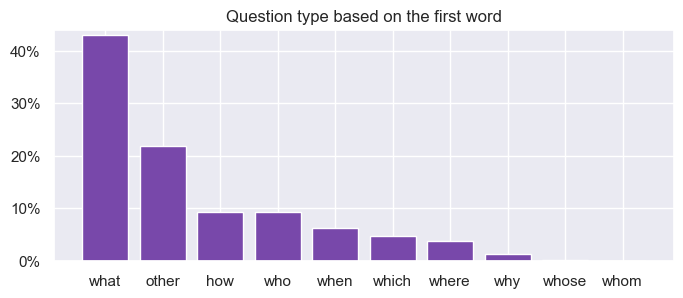

In [34]:
fig, _ = plt.subplots(1, 1)
fig.set_size_inches(8, 3)

plt.bar(question_words_freq.keys(), question_words_freq.values(), color='#7848aa')
plt.title("Question type based on the first word")
plt.yticks(plt.yticks()[0], ['{:,.0%}'.format(x) for x in plt.yticks()[0]])
plt.ylim([0.0, 0.44])

plt.show()
fig.savefig('../../results/question_types.png', dpi=300)